<a href="https://colab.research.google.com/github/HenriqueCCdA/bootCampAluraDataScience/blob/master/modulo4/extra/ICU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Pre-analise

## 1.1) Importando libs

In [474]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 50)

## 1.2) Funções

### 1.2.1 ) Funções de plotagem

In [475]:
def plot_barras(titulo, x, y):
    
    sns.set_style("white")

    pal = sns.color_palette("tab10", 5)

    fig, ax = plt.subplots(figsize=(10, 5))

    fig.text(x = 0.06, y = 0.95,
         s = titulo,
         fontsize=24, color = 'gray') 

    sns.barplot(y = y, 
            x = x*100, 
            ax = ax,
            palette = pal,
            orient = 'h')

# limite
#    ax.set_xlim(0, 100)

    ax.set_xlabel('Porcentagem (%)', loc = 'left', fontsize= 16, color='dimgray')
#ax.set_ylabel('Genêro', loc = 'top', fontsize= 16, color='dimgray')

    plt.xticks(fontsize= 16, color='gray')
    plt.yticks(fontsize= 16, color='gray')


    sns.despine()
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('gray')

    plt.show()

In [476]:
import sys
sys.path.insert(1, "../../")
import src.limpeza_dados as cl

# 2) Explorando os dados

# 2.1) Importando os dados

In [477]:
path = "https://github.com/HenriqueCCdA/BC_DS_Projeto_Final/blob/main/Dados/Brutos/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true"

dados = pd.read_excel(path)
dados.head(n=5)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


In [478]:
nl, nc = dados.shape
print(f"Numero de linhas : {nl} ")
print(f"Numero de colunas: {nc} ")

Numero de linhas : 1925 
Numero de colunas: 231 


In [479]:
print(dados.dtypes)

PATIENT_VISIT_IDENTIFIER        int64
AGE_ABOVE65                     int64
AGE_PERCENTIL                  object
GENDER                          int64
DISEASE GROUPING 1            float64
                               ...   
RESPIRATORY_RATE_DIFF_REL     float64
TEMPERATURE_DIFF_REL          float64
OXYGEN_SATURATION_DIFF_REL    float64
WINDOW                         object
ICU                             int64
Length: 231, dtype: object


In [480]:
dados.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1925.000000,1925.000000,1925.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,...,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1925.000000
mean,192.000000,0.467532,0.368831,0.108333,0.028125,0.097917,0.019792,0.128125,0.046875,0.213021,...,-0.703683,-0.770338,-0.887196,-0.786997,-0.715950,-0.817800,-0.719147,-0.771327,-0.886982,0.267532
std,111.168431,0.499074,0.482613,0.310882,0.165373,0.297279,0.139320,0.334316,0.211426,0.409549,...,0.482097,0.319001,0.296147,0.324754,0.419103,0.270217,0.446600,0.317694,0.296772,0.442787
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,96.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,192.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-0.976190,-0.979798,-1.000000,-0.984944,-0.989822,-1.000000,-0.975924,-0.980333,0.000000
75%,288.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.647059,-0.595238,-0.878788,-0.645482,-0.522176,-0.662529,-0.634409,-0.594677,-0.880155,1.000000
max,384.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [481]:
dados.iloc[:21,[0,-2,-1]]

,PATIENT_VISIT_IDENTIFIER,WINDOW,ICU
0,0,0-2,0
1,0,2-4,0
2,0,4-6,0
3,0,6-12,0
4,0,ABOVE_12,1
5,1,0-2,1
6,1,2-4,1
7,1,4-6,1
8,1,6-12,1
9,1,ABOVE_12,1


In [482]:
n_pacientes_inicial = len(dados['PATIENT_VISIT_IDENTIFIER'].unique())
print('Numero de pacientes', n_pacientes_inicial)

Numero de pacientes 385


In [483]:
dados['AGE_PERCENTIL'].unique()

array(['60th', '90th', '10th', '40th', '70th', '20th', '50th', '80th',
       '30th', 'Above 90th'], dtype=object)

In [484]:
names = ['HTN', 'IMMUNOCOMPROMISED', 'OTHER', 'GENDER', 'AGE_ABOVE65',
         'DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3',
         'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6',
         'WINDOW', 'ICU', 'AGE_PERCENTIL']
for name in names:
  print(f'{name:20} ->', dados[name].unique())

HTN                  -> [ 0.  1. nan]
IMMUNOCOMPROMISED    -> [ 0.  1. nan]
OTHER                -> [ 1.  0. nan]
GENDER               -> [0 1]
AGE_ABOVE65          -> [1 0]
DISEASE GROUPING 1   -> [ 0.  1. nan]
DISEASE GROUPING 2   -> [ 0.  1. nan]
DISEASE GROUPING 3   -> [ 0.  1. nan]
DISEASE GROUPING 4   -> [ 0.  1. nan]
DISEASE GROUPING 5   -> [ 1.  0. nan]
DISEASE GROUPING 6   -> [ 1.  0. nan]
WINDOW               -> ['0-2' '2-4' '4-6' '6-12' 'ABOVE_12']
ICU                  -> [0 1]
AGE_PERCENTIL        -> ['60th' '90th' '10th' '40th' '70th' '20th' '50th' '80th' '30th'
 'Above 90th']


In [485]:
for name in dados.columns:
  if 'ALBUMIN' in name:
    print(name)

ALBUMIN_MEDIAN
ALBUMIN_MEAN
ALBUMIN_MIN
ALBUMIN_MAX
ALBUMIN_DIFF


In [486]:
for name in dados.columns:
  if 'OXYGEN_SATURATION' in name:
    print(name)

OXYGEN_SATURATION_MEAN
OXYGEN_SATURATION_MEDIAN
OXYGEN_SATURATION_MIN
OXYGEN_SATURATION_MAX
OXYGEN_SATURATION_DIFF
OXYGEN_SATURATION_DIFF_REL


> Verificando as colunas que só tem dois valores únicos. No caso NaN e -1. Esta colunas sçao condidatas a exclusão pois como todas temo os mesmo valores não agrega nenhuma informação.

In [487]:
cl.colunas_com_apenas_n_valores_unicos(dados, 2)

Colunas com apenas 2 valores unicos:
ALBUMIN_DIFF         -> [nan -1.]
BE_ARTERIAL_DIFF     -> [nan -1.]
BE_VENOUS_DIFF       -> [nan -1.]
BIC_ARTERIAL_DIFF    -> [nan -1.]
BIC_VENOUS_DIFF      -> [nan -1.]
BILLIRUBIN_DIFF      -> [nan -1.]
BLAST_DIFF           -> [nan -1.]
CALCIUM_DIFF         -> [nan -1.]
CREATININ_DIFF       -> [nan -1.]
FFA_DIFF             -> [nan -1.]
GGT_DIFF             -> [nan -1.]
GLUCOSE_DIFF         -> [nan -1.]
HEMATOCRITE_DIFF     -> [nan -1.]
HEMOGLOBIN_DIFF      -> [nan -1.]
INR_DIFF             -> [nan -1.]
LACTATE_DIFF         -> [nan -1.]
LEUKOCYTES_DIFF      -> [nan -1.]
LINFOCITOS_DIFF      -> [nan -1.]
NEUTROPHILES_DIFF    -> [nan -1.]
P02_ARTERIAL_DIFF    -> [nan -1.]
P02_VENOUS_DIFF      -> [nan -1.]
PC02_ARTERIAL_DIFF   -> [nan -1.]
PC02_VENOUS_DIFF     -> [nan -1.]
PCR_DIFF             -> [nan -1.]
PH_ARTERIAL_DIFF     -> [nan -1.]
PH_VENOUS_DIFF       -> [nan -1.]
PLATELETS_DIFF       -> [nan -1.]
POTASSIUM_DIFF       -> [nan -1.]
SAT02_ARTER

## 2.2) Resumo:

>Geral:
* Número de linhas  : 1925 
* Número de colunas : 231
* Colunas 0, 1, 3 e 230 tipo int64
* Colunas 2 e 229 tipo string
* Colunas 4 a 228 tipo float64
* Número de pacientes: 385 (cada paciente tem mutiplicas entradas por janelas de tempo)

>Colunas categoricas 0 ou 1:
* HTN                  -> [ 0.  1. nan]
* IMMUNOCOMPROMISED    -> [ 0.  1. nan]
* OTHER                -> [ 1.  0. nan]
* GENDER               -> [0 1] [ mascilino feminio]
* AGE_ABOVE65          -> [1 0]
* DISEASE GROUPING 1   -> [ 0.  1. nan]
* DISEASE GROUPING 2   -> [ 0.  1. nan]
* DISEASE GROUPING 3   -> [ 0.  1. nan]
* DISEASE GROUPING 4   -> [ 0.  1. nan]
* DISEASE GROUPING 5   -> [ 1.  0. nan]
* DISEASE GROUPING 6   -> [ 1.  0. nan]

>Colunas categoricas Multi-Label:
* WINDOW               -> ['0-2' '2-4' '4-6' '6-12' 'ABOVE_12']
* AGE_PERCENTIL        -> ['60th' '90th' '10th' '40th' '70th' '20th' '50th' '80th' '30th'
 'Above 90th']

>Possivel divisão das idades:
* 10th - 0  a 10 anos
* 20th - 11 a 20 anos
* 30th - 21 a 30 anos
* 40th - 31 a 20 anos
* 50th - 41 a 50 anos
* 60th - 51 a 60 anos
* 70th - 71 a 80 anos
* 80th - 81 a 90 anos
* 90th - 91 a 100 anos
* Above 90th - 101 ... anos

>OBS:
* Hypertension (HTN) 
* Imunodepressivos (IMMUNOCOMPROMISED)  
* UTI (intensive care unit)

> Nas colunas 13 até 228 as variaveis são continuas
>
> Por exemplo:

* OXYGEN_SATURATION_MEDIAN - mediana 
* OXYGEN_SATURATION_MEAN   - media
* OXYGEN_SATURATION_MIN    - minimo
* OXYGEN_SATURATION_MAX    - maximo
* OXYGEN_SATURATION_DIFF   - max - min         
* OXYGEN_SATURATION_DIFF_REL  - diff/median - (max - min)/median  (**nem todos tem**)

> porém nem todas temo o campo **DIFF_REL**

>As colunas parecem ter apenas o valor -1

* ALBUMIN_DIFF        
* DE_ARTERIAL_DIFF    
* BE_VENOUS_DIFF      
* BIC_ARTERIAL_DIFF   
* BIC_VENOUS_DIFF     
* BILLIRUBIN_DIFF     
* BLAST_DIFF          
* CALCIUM_DIFF        
* CREATININ_DIFF      
* FFA_DIFF            
* GGT_DIFF            
* GLUCOSE_DIFF        
* HEMATOCRITE_DIFF    
* HEMOGLOBIN_DIFF     
* INR_DIFF            
* LACTATE_DIFF        
* LEUKOCYTES_DIFF     
* LINFOCITOS_DIFF     
* NEUTROPHILES_DIFF   
* P02_ARTERIAL_DIFF   
* P02_VENOUS_DIFF     
* PC02_ARTERIAL_DIFF  
* PC02_VENOUS_DIFF    
* PCR_DIFF            
* PH_ARTERIAL_DIFF    
* PH_VENOUS_DIFF      
* PLATELETS_DIFF      
* POTASSIUM_DIFF      
* SAT02_ARTERIAL_DIFF 
* SAT02_VENOUS_DIFF   
* SODIUM_DIFF         
* TGO_DIFF            
* TGP_DIFF            
* TTPA_DIFF           
* UREA_DIFF           
* DIMER_DIFF


# 3) Tratamento dos dados

In [488]:
dados.iloc[:21,[0,-2,-1]]

,PATIENT_VISIT_IDENTIFIER,WINDOW,ICU
0,0,0-2,0
1,0,2-4,0
2,0,4-6,0
3,0,6-12,0
4,0,ABOVE_12,1
5,1,0-2,1
6,1,2-4,1
7,1,4-6,1
8,1,6-12,1
9,1,ABOVE_12,1


> Pacientes que foram para uti por janela. Aqui temos que 32 pacientes foram para a UTI na janela 0-2.

In [489]:
ICU_window_0_2, _, _, _ = cl.pacientes_por_janela_ICU(dados)

Numero de ICU igual a 1
Janela 0-2 : 32
Janela 2-4 : 59
Janela 4-6 : 99
Janela 6-12: 130


In [490]:
ICU_window_0_2 # pacientes que precisam ser retirados

5         1
85       17
135      27
205      41
235      47
240      48
270      54
310      62
425      85
450      90
520     104
530     106
545     109
585     117
720     144
880     176
1010    202
1030    206
1130    226
1165    233
1195    239
1305    261
1350    270
1410    282
1430    286
1530    306
1575    315
1645    329
1795    359
1810    362
1830    366
1895    379
Name: PATIENT_VISIT_IDENTIFIER, dtype: int64

## 3.2) Manipulando os dados

* Retirando os pacientes que foram para a UTI na janela 0-2
* Preenchimento dos valores NaN nas variaveis continuas
* retirandos os valores NaN que restaram

In [491]:
dados_tratados = dados.copy()
# Retirando os pacientes que foram para a UTI na janela 0-2
dados_tratados = cl.retira_paciente_primeira_janela(dados_tratados)
# Preenchimento dos valores NaN nas variaveis continuas
dados_tratados = cl.preenchendo_var_continuas(dados_tratados)
# retira todas alinhas que ainda tem valores NaN
dados_tratados = dados_tratados.dropna()

In [492]:
dados_tratados.head(n=15)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1
5,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,0
6,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,2-4,0
7,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,4-6,0
8,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.797980,-0.658863,-0.563758,-0.721834,-0.926882,-1.000000,-0.801293,6-12,0
9,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.500000,-0.898990,-0.612422,-0.343258,-0.576744,-0.695341,-0.505464,-0.900129,ABOVE_12,1


## 3.2.1) Checando se os pacientes foram corretamente retirados

In [493]:
# verificando se tem algum paciente ICU no intervalo 0-2
_, _, _, _, = cl.pacientes_por_janela_ICU(dados_tratados)

Numero de ICU igual a 1
Janela 0-2 : 0
Janela 2-4 : 27
Janela 4-6 : 67
Janela 6-12: 98


## 3.2.2)  Checando se anda existem NaN

In [494]:
for col in dados_tratados:
  if dados_tratados[col].isna().sum():
    print("Valores NaN na coluna", col, dados_tratados[col].isna().sum())

In [495]:
nl, nc = dados_tratados.shape
print(f"Numero de linhas : {nl} ")
print(f"Numero de colunas: {nc} ")

Numero de linhas : 1645 
Numero de colunas: 231 


In [496]:
dados_tratados['AGE_PERCENTIL'].unique()

array(['60th', '10th', '40th', '70th', '20th', '50th', '80th', '30th',
       '90th', 'Above 90th'], dtype=object)

## 3.3) Retirando a colunas DIF e DIF_REL

> As colunas DIFF e DIFF_REL serão removidas pelo seguintes motivos:
* São correlacinadas com as outras
* Algumas delas apresentam apenos o valor -1 em todas as linhas

In [497]:
colunas_excluir = []
for name in dados_tratados:
    if ("DIFF" in name):
      colunas_excluir.append(name)
print(f'Número de colunas para exclusão : {len(colunas_excluir)}')

Número de colunas para exclusão : 48


In [498]:
dados_tratados = dados_tratados.drop(colunas_excluir, axis=1)
dados_tratados.head(n=5)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.318681,0.898990,-0.076923,-0.459459,-0.313433,-0.636364,-0.275362,0.736842,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,ABOVE_12,1


## 3.4) Uma linha por paciente

> Pegando as informações de apenas da janela 0-2

In [499]:
dados_tratados_por_paciente = dados_tratados\
                              .groupby('PATIENT_VISIT_IDENTIFIER', as_index=False)\
                              .apply(cl.uma_linha_por_paciente)

In [500]:
dados_tratados_por_paciente.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,0-2,1
1,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,0-2,1
2,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,0-2,0
3,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,0-2,0
4,5,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.252747,0.919192,-0.247863,-0.567568,-0.626866,-0.575758,-0.333333,0.842105,0-2,0


In [501]:
n_pacientes, _ = dados_tratados_por_paciente.shape
print(f"Numero de pacientes inicial : {n_pacientes_inicial}")
print(f"Numero de pacientes validos : {n_pacientes} ")

Numero de pacientes inicial : 385
Numero de pacientes validos : 351 


> Verificando novamente as colunas que só tem um valor único. 

In [502]:
cl.colunas_com_apenas_n_valores_unicos(dados_tratados_por_paciente, 1)

Colunas com apenas 1 valores unicos:


## 3.5) Modificando a coluna AGE_PERCENTIL

AGE_PERCENTIL| valor proposto |
:-----------:|:--------------:|
   10th      |    0  |
   20th      |    1  |          
   30th      |    2  |     
   40th      |    3  |     
   50th      |    4  | 
   60th      |    5  |       
   70th      |    6  | 
   80th      |    7  |
   90th      |    8  |
   Above 90th|    9  |          


In [514]:
valores = np.array([0,1,2,3,4,5,6,7,8,9])

media = np.mean(valores)
z = valores - media
max   = np.abs(np.max(z))
z = z / max
#z = valores
z 

array([-1.        , -0.77777778, -0.55555556, -0.33333333, -0.11111111,
        0.11111111,  0.33333333,  0.55555556,  0.77777778,  1.        ])

In [515]:
mapi = { '10th'      : z[0], '20th'      : z[1], '30th'      : z[2],
         '40th'      : z[3], '50th'      : z[4], '60th'      : z[5],
         '70th'      : z[6], '80th'      : z[7], '90th'      : z[8],
         'Above 90th': z[9],
} 

In [516]:
age_percentil_original = dados_tratados_por_paciente['AGE_PERCENTIL']
dados_tratados_por_paciente['AGE_PERCENTIL'] = dados_tratados_por_paciente['AGE_PERCENTIL'].map(mapi)
dados_tratados_por_paciente['AGE_PERCENTIL'].dtype # checando o tipo

dtype('float64')

In [517]:
dados_tratados_por_paciente['AGE_PERCENTIL'].unique() # verifica se deu certo a substituicao

array([ 0.11111111, -1.        , -0.33333333,  0.33333333, -0.77777778,
       -0.11111111,  0.55555556, -0.55555556,  0.77777778,  1.        ])

In [518]:
dados_tratados_por_paciente.head(n=15)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,WINDOW,ICU
0,0,1,0.111111,0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,0-2,1
1,2,0,-1.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,0-2,1
2,3,0,-0.333333,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,0-2,0
3,4,0,-1.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,0-2,0
4,5,0,-1.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.252747,0.919192,-0.247863,-0.567568,-0.626866,-0.575758,-0.333333,0.842105,0-2,0
5,6,1,0.333333,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.494505,0.959596,-0.452991,-0.610811,-0.537313,-0.636364,-0.043478,0.894737,0-2,0
6,7,0,-0.777778,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.208791,0.939394,-0.179487,-0.491892,-0.671642,-0.454545,-0.420290,0.842105,0-2,0
7,8,0,-0.111111,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.670330,0.919192,-0.435897,-0.740541,-0.462687,-0.636364,0.188406,0.789474,0-2,0
8,9,1,0.555556,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.186813,0.939394,-0.247863,-0.351351,-0.462687,-0.696970,-0.449275,0.842105,0-2,0
9,10,1,0.555556,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.450549,0.919192,-0.128205,-0.502703,-0.805970,-0.696970,-0.101449,0.789474,0-2,0


# 4) Explorando dados finais

## 4.1) Distribuição por genero

In [519]:
val = dados_tratados_por_paciente['GENDER'].value_counts(normalize=True)

print(f'Genero = {val.index[0]} p = {val.values[0]*100:.2f} %')
print(f'Genero = {val.index[1]} p = {val.values[1]*100:.2f} %')

Genero = 0 p = 61.82 %
Genero = 1 p = 38.18 %


In [520]:
def plot_barras(titulo, x, y, xlim, n_colors=10):
    
    sns.set_style("white")

#    pal = sns.color_palette("tab10", 10)
    pal = sns.color_palette('BuPu', n_colors)

    fig, ax = plt.subplots(figsize=(10, 5))

    fig.text(x = 0.06, y = 0.95,
         s = titulo,
         fontsize=24, color = 'gray') 

    sns.barplot(y = y, 
            x = x*100, 
            ax = ax,
            palette = pal,
            orient = 'h')

# limite
    ax.set_xlim(xlim)

    ax.set_xlabel('Porcentagem (%)', loc = 'left', fontsize= 16, color='dimgray')
#ax.set_ylabel('Genêro', loc = 'top', fontsize= 16, color='dimgray')

    plt.xticks(fontsize= 16, color='gray')
    plt.yticks(fontsize= 16, color='gray')


    sns.despine()
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('gray')

    plt.show()

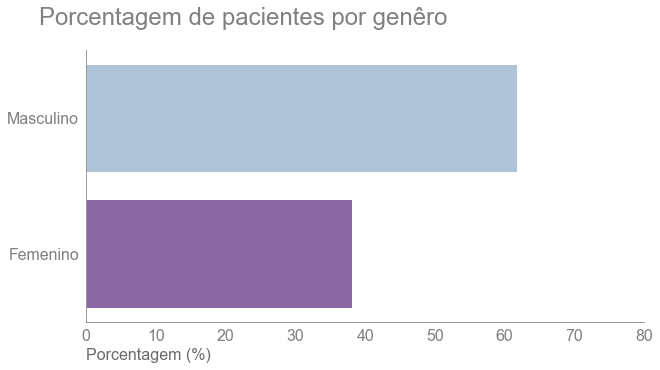

In [521]:
plot_barras(titulo = 'Porcentagem de pacientes por genêro',
            x = val.values, 
            y = ['Masculino', 'Femenino'],
            xlim=(0,80),
            n_colors=2)

> Podemos observar que existe uma predominancia de pacientes do genero ```masculino``` de ```61.82%```

## 4.2) Distribuição por percentil de idade

In [543]:
val = dados_tratados_por_paciente['AGE_PERCENTIL'].value_counts(normalize=True)
for ind, vals in zip(val.index, val.values):
    print(f'Percentil idade = {ind:.2f} p = {vals*100:.2f} %')

Percentil idade = -0.78 p = 11.97 %
Percentil idade = -0.56 p = 11.11 %
Percentil idade = -0.33 p = 10.83 %
Percentil idade = -1.00 p = 10.26 %
Percentil idade = 0.56 p = 10.26 %
Percentil idade = -0.11 p = 9.69 %
Percentil idade = 1.00 p = 9.69 %
Percentil idade = 0.33 p = 9.69 %
Percentil idade = 0.11 p = 8.55 %
Percentil idade = 0.78 p = 7.98 %


In [544]:
val = age_percentil_original.value_counts(normalize=True) 
for ind, vals in zip(val.index, val.values):
    print(f'Percentil idade = {ind:} p = {vals*100:.2f} %')

Percentil idade = 20th p = 11.97 %
Percentil idade = 30th p = 11.11 %
Percentil idade = 40th p = 10.83 %
Percentil idade = 80th p = 10.26 %
Percentil idade = 10th p = 10.26 %
Percentil idade = 50th p = 9.69 %
Percentil idade = 70th p = 9.69 %
Percentil idade = Above 90th p = 9.69 %
Percentil idade = 60th p = 8.55 %
Percentil idade = 90th p = 7.98 %


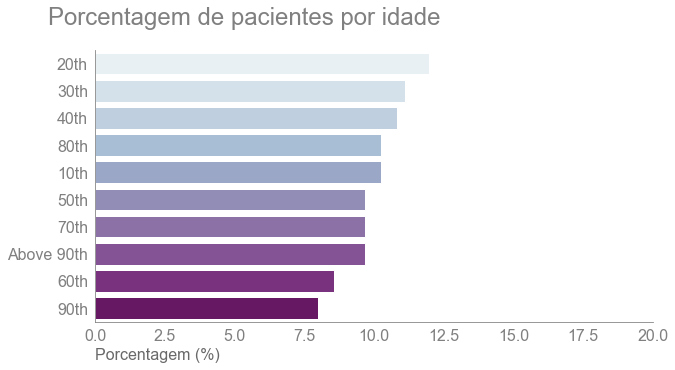

In [545]:
plot_barras(x = val.values,
            y = val.index, 
            titulo = 'Porcentagem de pacientes por idade',
            xlim=(0,20))

> O percentil daAs idades com mais pacientes são ```20```, ```30, 40, 80 e 10 

In [546]:
p_pacientes_acima_de_70 = val['70th'] + val['80th'] + val['90th'] + val['Above 90th']
p_pacientes_acima_de_60 = val['60th'] + p_pacientes_acima_de_70
print(f'Porcentagem de pacientes acima de 70 anos : {p_pacientes_acima_de_70*100:.2f} %')
print(f'Porcentagem de pacientes acima de 60 anos : {p_pacientes_acima_de_60*100:.2f} %')

Porcentagem de pacientes acima de 70 anos : 37.61 %
Porcentagem de pacientes acima de 60 anos : 46.15 %


## 4.3) Distribuição por Above_65

In [552]:
f = {0: 'Abaixo de 65', 1: 'Acima de 65'}

val = dados_tratados_por_paciente['AGE_ABOVE65'].value_counts(normalize=True)

for ind, vals in zip(val.index, val.values):
    print(f'{f[ind]} p = {vals*100:.2f} %')

Abaixo de 65 p = 54.13 %
Acima de 65 p = 45.87 %


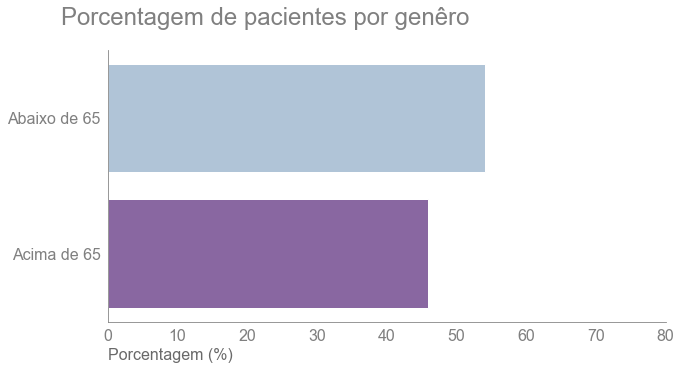

In [550]:
plot_barras(titulo = 'Porcentagem de pacientes por genêro',
            x = val.values, 
            y = ['Abaixo de 65', 'Acima de 65'],
            xlim=(0,80),
            n_colors=2)

> Temos cerca de ```45.87%``` de pacientes acima de ```65```. Considerando que ´´´46.15%´´´ estão acima de ```60``` podesse concluir que temos ```0.28%``` entre ```60``` a ```64``` anos.

# 5) Salvando os dados tratados 

In [ ]:
dados_tratados_por_paciente.to_csv('dados_tratados_por_paciente.csv', index_label=False)